# Example 1: Sorting

This is a notebook demonstrating how to use Cython and [stdpar](https://developer.nvidia.com/blog/accelerating-standard-c-with-gpus-using-stdpar/) to accelerate Python code.

This example is centered on a simple task: sorting a sequence of integers

## Setup <a name="setup"></a>

Some essential imports and utility functions for benchmarking:

In [1]:
import timeit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import format_time

In [2]:
plt.rcParams.update({'font.size': 15})

In [3]:
def random_data(size):
    return np.random.randint(size, size=size, dtype="int32")

In [4]:
def time_sort(size, sort_func):
    repeat = 10
    dt = 0
    for i in range(repeat):
        data = random_data(size)
        start = timeit.default_timer()
        sort_func(data)
        end = timeit.default_timer()
        dt += (end - start)
    return (dt) / repeat

In [5]:
def run_benchmark(sort_func, name):
    sizes = [100, 1_000, 10_000, 100_000, 1_000_000, 10_000_000]
    return pd.Series(
        [time_sort(s, sort_func) for s in sizes],
        index=sizes,
        name=name
    )

## Calling `std::sort` from Cython

In `cppsort_serial.pyx` below, we define a function `cppsort` that uses the C++ `std::sort` function to sort an input array:

In [6]:
%%writefile cppsort_serial.pyx

# distutils: language=c++

from libcpp.algorithm cimport sort

def cppsort(int[:] x):
    sort(&x[0], &x[-1] + 1) 

Writing cppsort_serial.pyx


To use the `cppsort` function from Python, we need to first build it into an extension module. The following command does just that. Comment out the `%%capture` line to see the output from the compilation and/or to debug any issues.

In [7]:
%%capture
!python setup.py build_ext --inplace

The following code times the execution of `cppsort` for various input sizes, and prints the results:

In [8]:
from cppsort_serial import cppsort

cpu_serial = run_benchmark(cppsort, "CPU serial")
cpu_serial.map(format_time).to_frame()

,CPU serial
100,12.620724737644196 µs
1000,106.54041543602943 µs
10000,988.004542887211 µs
100000,5.549234244972467 ms
1000000,63.390801008790724 ms
10000000,739.3174688331783 ms


In [9]:
!rm -f cppsort_serial.pyx

## Parallelizing `std::sort` using CPU threads

We extend the `cppsort` function above by passing the [parallel execution policy](https://en.cppreference.com/w/cpp/algorithm/execution_policy_tag_t) to `std::sort`. For this to work correctly, we must link the [tbb](https://github.com/oneapi-src/oneTBB) library, which provides a parallel implementation of `std::sort`.

In [10]:
%%writefile cppsort_parallel.pyx

# distutils: language=c++
# distutils: libraries=tbb

from execution cimport par
from algorithm cimport sort

def cppsort(int[:] x):
    sort(par, &x[0], &x[-1] + 1)

Writing cppsort_parallel.pyx


In [11]:
%%capture
!python setup.py build_ext --inplace

In [12]:
try:
    from cppsort_parallel import cppsort

    cpu_parallel = run_benchmark(cppsort, "CPU parallel")
    cpu_parallel.map(format_time).to_frame()
except ImportError:  # handle if TBB is missing
    cpu_parallel = cpu_serial.replace(cpu_serial.values, pd.NA).rename("CPU parallel")

In [13]:
!rm -f cppsort_parallel.pyx  # cleanup temp file

## `std::sort` on the GPU using stdpar

Finally, `cppsort_stdpar` below is compiled with `nvc++` and the [stdpar](https://developer.nvidia.com/blog/accelerating-standard-c-with-gpus-using-stdpar/) option. This will offload execution to the GPU.

Also note that the input is copied to a (temporary) local buffer and back. This is required because `-stdpar` does not work with externally allocated memory.

In [14]:
%%writefile cppsort_stdpar.pyx

# distutils: language=c++

from libcpp.algorithm cimport copy_n
from libcpp.vector cimport vector

from execution cimport par
from algorithm cimport sort


def cppsort(int[:] x):
    """
    Sort the elements of x "in-place" using std::sort
    """
    cdef vector[int] vec
    vec.resize(len(x))
    copy_n(&x[0], len(x), vec.begin())
    sort(par, vec.begin(), vec.end())
    copy_n(vec.begin(), len(x), &x[0])

Writing cppsort_stdpar.pyx


In [15]:
%%capture
!CC=nvc++ python setup.py build_ext --inplace

In [16]:
from cppsort_stdpar import cppsort

gpu_stdpar = run_benchmark(cppsort, "GPU (nvc++ with -stdpar)")
gpu_stdpar.map(format_time).to_frame()

,GPU (nvc++ with -stdpar)
100,15.674544032663107 ms
1000,425.72310194373136 µs
10000,1.2178449891507626 ms
100000,1.5216481871902943 ms
1000000,3.838073927909136 ms
10000000,33.395095355808735 ms


In [17]:
!rm -f cppsort_sdpar.pyx

## Comparing performance

Finally, we plot the speedups over a baseline implementation (NumPy's `.sort()` method):

In [18]:
baseline = run_benchmark(lambda x: x.sort(), "NumPy")

In [19]:
all_timings = pd.DataFrame([baseline, cpu_serial, cpu_parallel, gpu_stdpar]).T
speedups = (1/all_timings).multiply(baseline, axis=0)

In [20]:
all_timings.applymap(format_time)

,NumPy,CPU serial,CPU parallel,GPU (nvc++ with -stdpar)
100,58.26130509376526 µs,12.620724737644196 µs,296.5981140732765 µs,15.674544032663107 ms
1000,99.59693998098373 µs,106.54041543602943 µs,125.98074972629547 µs,425.72310194373136 µs
10000,1.0074754245579243 ms,988.004542887211 µs,286.58006340265274 µs,1.2178449891507626 ms
100000,5.564538016915321 ms,5.549234244972467 ms,1.4682461507618427 ms,1.5216481871902943 ms
1000000,62.955435551702976 ms,63.390801008790724 ms,11.471819132566452 ms,3.838073927909136 ms
10000000,733.2862354815006 ms,739.3174688331783 ms,132.79978027567267 ms,33.395095355808735 ms


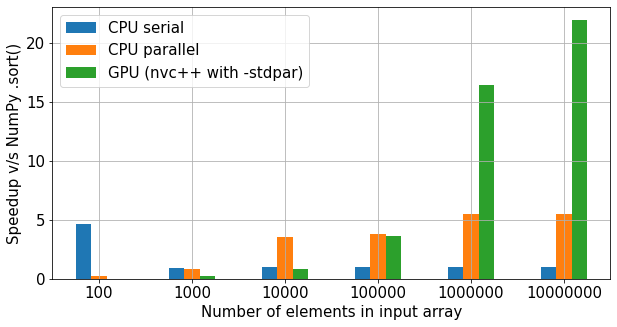

In [21]:
speedups.iloc[:, 1:].plot(
    kind="bar", 
    xlabel="Number of elements in input array", 
    ylabel="Speedup v/s NumPy .sort()", 
    figsize=(10, 5),
    grid=True
)
plt.xticks(rotation=0)
plt.savefig("sort.png")